In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 'n_iter', 
                         'train_accuracy', 'val_accuracy']] = cv_results[['param_C', 'mean_fit_time', 'mean_train_n_iter', 
                                                                          'mean_train_accuracy', 'mean_test_accuracy']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

In [59]:
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

lin_X, lin_y = generate_linearly_separable_overlap_data()
nonlin_X, nonlin_y = generate_nonlinearly_separable_data()

## Hinge loss

### Primal formulation

In [60]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [168]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


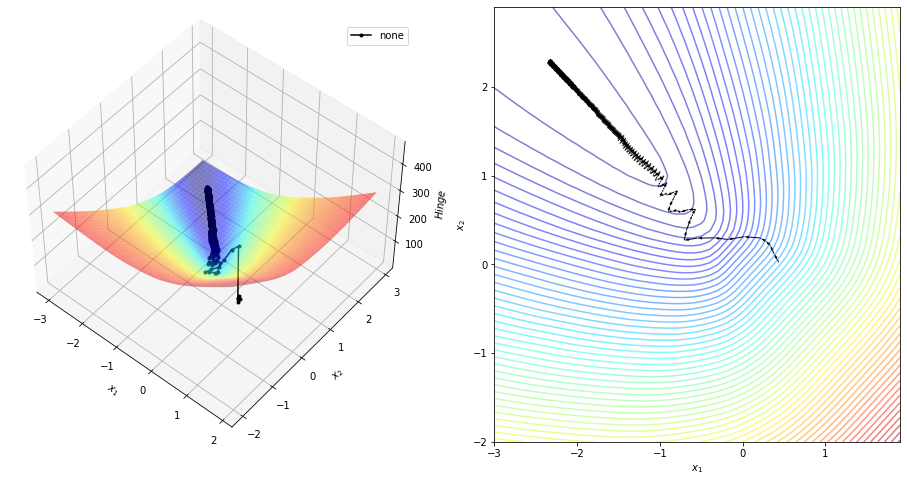

In [169]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, grid.best_estimator_.optimizer, color='k', label='none')

In [170]:
none_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_hinge_cv_results.insert(2, 'momentum', 'none')
none_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
none_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.794316     412        0.982494      0.979949   
       10  none      0.848348     483        0.984981      0.984999   
       100 none      0.449329     243        0.989994      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              37        18  
       10  none              10         6  
       100 none               9         5

Fitting 3 folds for each of 3 candidates, totalling 9 fits


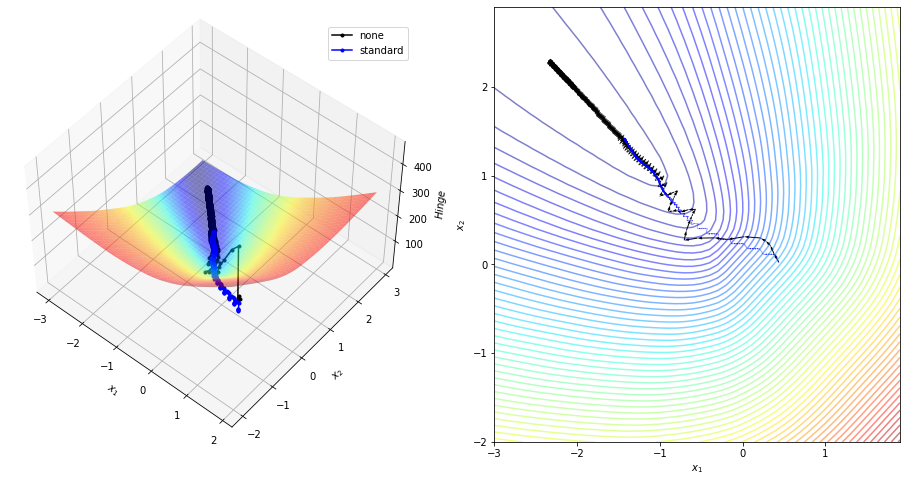

In [171]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='standard', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='b', label='standard')
hinge_loss_opt

In [172]:
standard_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_hinge_cv_results.insert(2, 'momentum', 'standard')
standard_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
standard_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   standard  0.526508     274        0.984981      0.984999   
       10  standard  0.652050     375        0.987487      0.989974   
       100 standard  0.348258     161        0.989994      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   standard          33        17  
       10  standard          10         6  
       100 standard           7         4

Fitting 3 folds for each of 3 candidates, totalling 9 fits


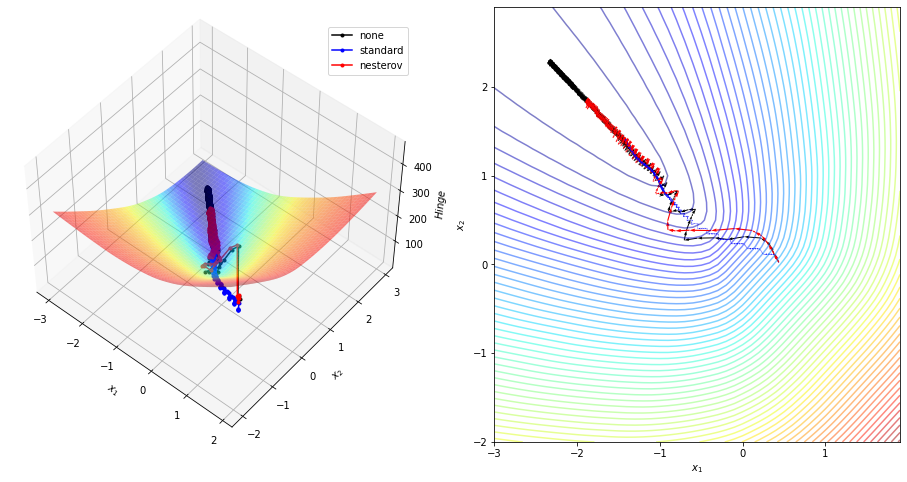

In [173]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='nesterov', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='r', label='nesterov')
hinge_loss_opt.savefig('./tex/img/svc_hinge_loss.png')
hinge_loss_opt

In [174]:
nesterov_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_hinge_cv_results.insert(2, 'momentum', 'nesterov')
nesterov_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
nesterov_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   nesterov  0.506168     274        0.984981      0.984999   
       10  nesterov  0.485980     296        0.984981      0.984999   
       100 nesterov  0.134886      58        0.989994      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   nesterov          33        17  
       10  nesterov          10         6  
       100 nesterov           8         5

In [175]:
custom_primal_svc_hinge_cv_results = none_primal_svc_hinge_cv_results.append(standard_primal_svc_hinge_cv_results).append(nesterov_primal_svc_hinge_cv_results)
custom_primal_svc_hinge_cv_results.sort_values('C', inplace=True)
custom_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.794316     412        0.982494      0.979949   
           standard  0.526508     274        0.984981      0.984999   
           nesterov  0.506168     274        0.984981      0.984999   
       10  none      0.848348     483        0.984981      0.984999   
           standard  0.652050     375        0.987487      0.989974   
           nesterov  0.485980     296        0.984981      0.984999   
       100 none      0.449329     243        0.989994      0.989974   
           standard  0.348258     161        0.989994      0.989974   
           nesterov  0.134886      58        0.989994      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              37        18  
           standard          33        17  
           nesterov          33        17  
       10  none              10         6  
           standard          10         6  
           nesterov          10         6  
       100 none               9         5  
           standard           7         4  
           nesterov           8         5

In [176]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [177]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
liblinear 1   -         0.001573     428        0.989994      0.989974   
          10  -         0.001447     744        0.987487      0.984999   
          100 -         0.001453    1000        0.985000      0.989974   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 11         6  
          10  -                  5         4  
          100 -                  7         2

In [178]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', 
                                     caption='SVC Primal formulation results with Hinge loss', 
                                     label='primal_svc_hinge_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
sgd       1   none      0.794316     412        0.982494      0.979949   
              standard  0.526508     274        0.984981      0.984999   
              nesterov  0.506168     274        0.984981      0.984999   
          10  none      0.848348     483        0.984981      0.984999   
              standard  0.652050     375        0.987487      0.989974   
              nesterov  0.485980     296        0.984981      0.984999   
          100 none      0.449329     243        0.989994      0.989974   
              standard  0.348258     161        0.989994      0.989974   
              nesterov  0.134886      58        0.989994      0.989974   
liblinear 1   -         0.001573     428        0.989994      0.989974   
          10  -         0.001447     744        0.987487      0.984999   
          100 -         0.001453    1000        0.985000      0.989974   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
sgd       1   none              37        18  
              standard          33        17  
              nesterov          33        17  
          10  none              10         6  
              standard          10         6  
              nesterov          10         6  
          100 none               9         5  
              standard           7         4  
              nesterov           8         5  
liblinear 1   -                 11         6  
          10  -                  5         4  
          100 -                  7         2

### Dual formulations

In [76]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [77]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [78]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


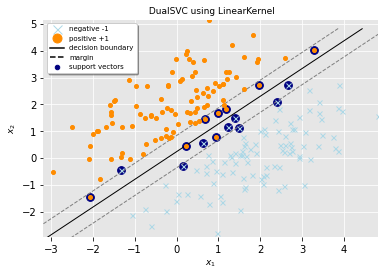

In [80]:
grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [81]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
cvxopt 1    0.020731      10           0.985      0.989974          12   
       10   0.016735      10           0.985      0.989974           7   
       100  0.029245      10           0.985      0.989974           8   
smo    1    0.076588      61           0.985      0.989974          12   
       10   0.076181      73           0.985      0.979949           7   
       100  0.373685    1196           0.985      0.989974           6   

            val_n_sv  
solver C              
cvxopt 1          12  
       10          7  
       100         8  
smo    1          12  
       10          7  
       100         6

In [83]:
grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM]

In [84]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
libsvm 1    0.003042      99        0.987487      0.989974          12   
       10   0.002565      90        0.987487      0.984999           7   
       100  0.003477    2647        0.985000      0.984999           6   

            val_n_sv  
solver C              
libsvm 1          12  
       10          7  
       100         6

In [85]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', 
                                    caption='Linear SVC Wolfe Dual formulation results with Hinge loss', 
                                    label='linear_dual_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
smo    1    0.076588      61        0.985000      0.989974          12   
       10   0.076181      73        0.985000      0.979949           7   
       100  0.373685    1196        0.985000      0.989974           6   
libsvm 1    0.003042      99        0.987487      0.989974          12   
       10   0.002565      90        0.987487      0.984999           7   
       100  0.003477    2647        0.985000      0.984999           6   
cvxopt 1    0.020731      10        0.985000      0.989974          12   
       10   0.016735      10        0.985000      0.989974           7   
       100  0.029245      10        0.985000      0.989974           8   

            val_n_sv  
solver C              
smo    1          12  
       10          7  
       100         6  
libsvm 1          12  
       10          7  
       100         6  
cvxopt 1          12  
       10          7  
       100         8

##### Nonlinear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


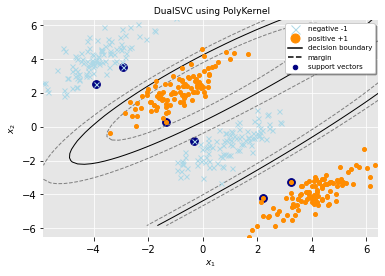

In [88]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [89]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.105617      10        0.851206      0.678412          28   
              10   0.095708      10        0.911206      0.688026          10   
              100  0.072921      10        0.916209      0.722889           9   
smo    poly   1    0.356696      88        0.851206      0.678412          28   
              10   0.270690     105        0.897426      0.660682           9   
              100  0.255688     198        0.916209      0.727921           8   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          28  
              10         10  
              100         9  
smo    poly   1          28  
              10          9  
              100         8

Fitting 3 folds for each of 6 candidates, totalling 18 fits


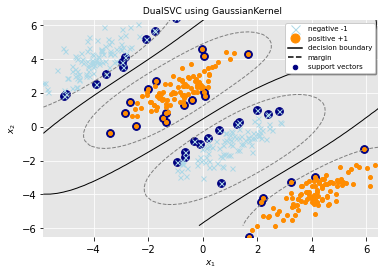

In [90]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [91]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt rbf    1    0.093452      10             1.0           1.0          43   
              10   0.073576      10             1.0           1.0          14   
              100  0.069153      10             1.0           1.0          13   
smo    rbf    1    0.245166      49             1.0           1.0          41   
              10   0.204894      52             1.0           1.0          13   
              100  0.188844      64             1.0           1.0          11   

                   val_n_sv  
solver kernel C              
cvxopt rbf    1          43  
              10         14  
              100        13  
smo    rbf    1          41  
              10         13  
              100        11

In [92]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.105617      10        0.851206      0.678412          28   
              10   0.095708      10        0.911206      0.688026          10   
              100  0.072921      10        0.916209      0.722889           9   
       rbf    1    0.093452      10        1.000000      1.000000          43   
              10   0.073576      10        1.000000      1.000000          14   
              100  0.069153      10        1.000000      1.000000          13   
smo    poly   1    0.356696      88        0.851206      0.678412          28   
              10   0.270690     105        0.897426      0.660682           9   
              100  0.255688     198        0.916209      0.727921           8   
       rbf    1    0.245166      49        1.000000      1.000000          41   
              10   0.204894      52        1.000000      1.000000          13   
              100  0.188844      64        1.000000      1.000000          11   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          28  
              10         10  
              100         9  
       rbf    1          43  
              10         14  
              100        13  
smo    poly   1          28  
              10          9  
              100         8  
       rbf    1          41  
              10         13  
              100        11

In [93]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LibSVM]

In [94]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
libsvm poly   1    0.005154     160             1.0      0.992481          28   
              10   0.004598     436             1.0      0.987469          10   
              100  0.006573     149             1.0      0.987469           8   
       rbf    1    0.004991     115             1.0      1.000000          41   
              10   0.002472     164             1.0      1.000000          13   
              100  0.003032     268             1.0      1.000000          12   

                   val_n_sv  
solver kernel C              
libsvm poly   1          28  
              10         10  
              100         8  
       rbf    1          41  
              10         13  
              100        12

In [95]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', 
                                       caption='Nonlinear SVC Wolfe Dual formulation results with Hinge loss', 
                                       label='nonlinear_dual_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
smo    poly   1    0.356696      88        0.851206      0.678412          28   
              10   0.270690     105        0.897426      0.660682           9   
              100  0.255688     198        0.916209      0.727921           8   
       rbf    1    0.245166      49        1.000000      1.000000          41   
              10   0.204894      52        1.000000      1.000000          13   
              100  0.188844      64        1.000000      1.000000          11   
libsvm poly   1    0.005154     160        1.000000      0.992481          28   
              10   0.004598     436        1.000000      0.987469          10   
              100  0.006573     149        1.000000      0.987469           8   
       rbf    1    0.004991     115        1.000000      1.000000          41   
              10   0.002472     164        1.000000      1.000000          13   
              100  0.003032     268        1.000000      1.000000          12   
cvxopt poly   1    0.105617      10        0.851206      0.678412          28   
              10   0.095708      10        0.911206      0.688026          10   
              100  0.072921      10        0.916209      0.722889           9   
       rbf    1    0.093452      10        1.000000      1.000000          43   
              10   0.073576      10        1.000000      1.000000          14   
              100  0.069153      10        1.000000      1.000000          13   

                   val_n_sv  
solver kernel C              
smo    poly   1          28  
              10          9  
              100         8  
       rbf    1          41  
              10         13  
              100        11  
libsvm poly   1          28  
              10         10  
              100         8  
       rbf    1          41  
              10         13  
              100        12  
cvxopt poly   1          28  
              10         10  
              100         9  
       rbf    1          43  
              10         14  
              100        13

#### Lagrangian Dual

##### Linear

In [96]:
grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [97]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], ascending=False, inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', 
                                               caption='Linear SVC Lagrangian Dual formulation results with Hinge loss', 
                                               label='linear_lagrangian_dual_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  val_n_sv
dual C                                                                        
qp   1    0.006492       1        0.985019      0.989974         131       131
     10   0.006105       1        0.985019      0.989974         131       131
     100  0.005686       1        0.985019      0.989974         131       131
bcqp 1    0.006973       1        0.985019      0.989974         130       130
     10   0.006043       1        0.985019      0.989974         130       130
     100  0.005027       1        0.985019      0.989974         130       130

##### Nonlinear

In [98]:
grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [99]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', 
                                                  caption='Nonlinear SVC Lagrangian Dual formulation results with Hinge loss', 
                                                  label='nonlinear_lagrangian_dual_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
dual kernel C                                                                 
qp   poly   1    1.315738     255        0.733773      0.513784         184   
            10   1.178677     255        0.733773      0.513784         184   
            100  1.203893     255        0.733773      0.513784         184   
     rbf    1    1.241991     229        0.822618      0.727734         186   
            10   1.696262     376        0.751255      0.503741         153   
            100  1.312007     305        0.833652      0.586447         178   
bcqp poly   1    1.480641     337        0.783729      0.538810         199   
            10   1.266989     337        0.783729      0.538810         199   
            100  1.023042     337        0.783729      0.538810         199   
     rbf    1    0.020001       1        0.998747      0.982568         240   
            10   0.021672       1        0.998747      0.982568         240   
            100  0.023396       1        0.998747      0.982568         240   

                 val_n_sv  
dual kernel C              
qp   poly   1         184  
            10        184  
            100       184  
     rbf    1         186  
            10        153  
            100       178  
bcqp poly   1         199  
            10        199  
            100       199  
     rbf    1         240  
            10        240  
            100       240

## Squared Hinge loss

### Primal formulation

In [100]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [179]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


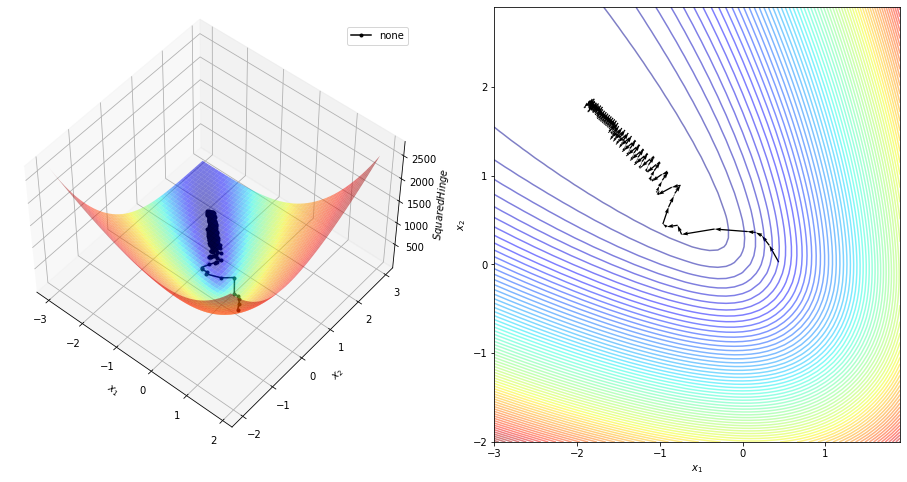

In [180]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, grid.best_estimator_.optimizer, 
                                                      color='k', label='none')

In [181]:
none_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_squared_hinge_cv_results.insert(2, 'momentum', 'none')
none_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
none_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.354329     188        0.982494      0.979949   
       10  none      0.149398      70        0.984981      0.980024   
       100 none      0.082154      27        0.989994      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              37        19  
       10  none              16         9  
       100 none              10         5

Fitting 3 folds for each of 3 candidates, totalling 9 fits


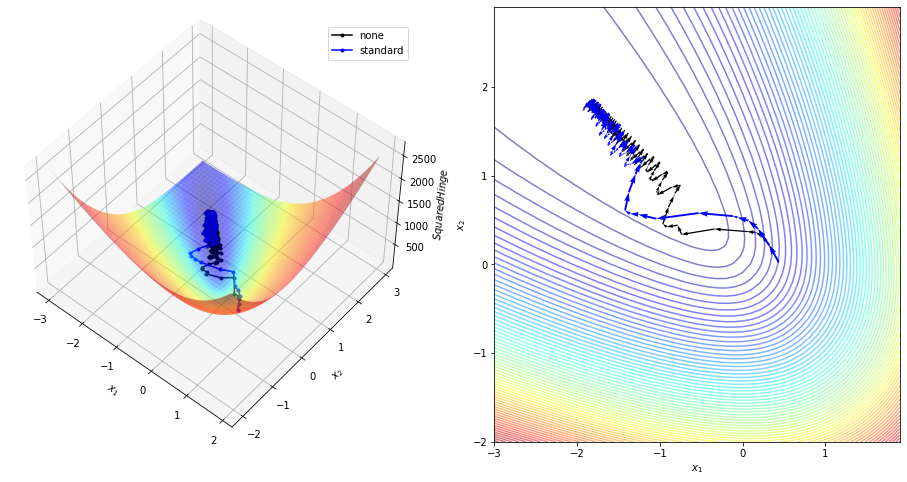

In [182]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='b', label='standard')
squared_hinge_loss_opt

In [183]:
standard_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_squared_hinge_cv_results.insert(2, 'momentum', 'standard')
standard_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
standard_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   standard  0.241015     124        0.984981      0.979949   
       10  standard  0.109080      44        0.984981      0.980024   
       100 standard  0.066164      28        0.987487      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   standard          34        17  
       10  standard          15         8  
       100 standard           8         5

Fitting 3 folds for each of 3 candidates, totalling 9 fits


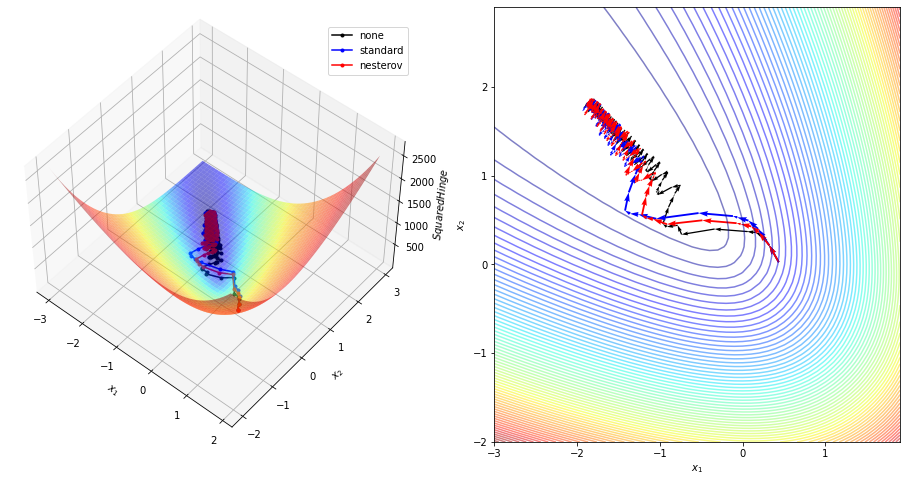

In [184]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='r', label='nesterov')
squared_hinge_loss_opt.savefig('./tex/img/svc_squared_hinge_loss.png')
squared_hinge_loss_opt

In [185]:
nesterov_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_squared_hinge_cv_results.insert(2, 'momentum', 'nesterov')
nesterov_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
nesterov_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   nesterov  0.227615     124        0.982494      0.979949   
       10  nesterov  0.103791      44        0.984981      0.980024   
       100 nesterov  0.069237      24        0.989994      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   nesterov          34        17  
       10  nesterov          15         9  
       100 nesterov           9         5

In [186]:
custom_primal_svc_squared_hinge_cv_results = none_primal_svc_squared_hinge_cv_results.append(standard_primal_svc_squared_hinge_cv_results).append(nesterov_primal_svc_squared_hinge_cv_results)
custom_primal_svc_squared_hinge_cv_results.sort_values('C', inplace=True)
custom_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.354329     188        0.982494      0.979949   
           standard  0.241015     124        0.984981      0.979949   
           nesterov  0.227615     124        0.982494      0.979949   
       10  none      0.149398      70        0.984981      0.980024   
           standard  0.109080      44        0.984981      0.980024   
           nesterov  0.103791      44        0.984981      0.980024   
       100 none      0.082154      27        0.989994      0.989974   
           standard  0.066164      28        0.987487      0.989974   
           nesterov  0.069237      24        0.989994      0.989974   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              37        19  
           standard          34        17  
           nesterov          34        17  
       10  none              16         9  
           standard          15         8  
           nesterov          15         9  
       100 none              10         5  
           standard           8         5  
           nesterov           9         5

In [187]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [188]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
liblinear 1   -         0.001429     366           0.985      0.989974   
          10  -         0.002015    1000           0.985      0.989974   
          100 -         0.001806    1000           0.985      0.980024   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 18        10  
          10  -                 14         8  
          100 -                 13         7

In [189]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', 
                                             caption='SVC Primal formulation results with Squared Hinge loss', 
                                             label='primal_svc_squared_hinge_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
sgd       1   none      0.354329     188        0.982494      0.979949   
              standard  0.241015     124        0.984981      0.979949   
              nesterov  0.227615     124        0.982494      0.979949   
          10  none      0.149398      70        0.984981      0.980024   
              standard  0.109080      44        0.984981      0.980024   
              nesterov  0.103791      44        0.984981      0.980024   
          100 none      0.082154      27        0.989994      0.989974   
              standard  0.066164      28        0.987487      0.989974   
              nesterov  0.069237      24        0.989994      0.989974   
liblinear 1   -         0.001429     366        0.985000      0.989974   
          10  -         0.002015    1000        0.985000      0.989974   
          100 -         0.001806    1000        0.985000      0.980024   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
sgd       1   none              37        19  
              standard          34        17  
              nesterov          34        17  
          10  none              16         9  
              standard          15         8  
              nesterov          15         9  
          100 none              10         5  
              standard           8         5  
              nesterov           9         5  
liblinear 1   -                 18        10  
          10  -                 14         8  
          100 -                 13         7